## Barrier tunnelling

To model the reverse-bias leakage current due to barrier tunneling (BT) in a $\beta-Ga_2O_3$ Schottky diode:

\begin{equation}
J_{\text{BT}} = \frac{A^* T}{k_B} \int_{-\infty}^{\mathcal{E}_{c,\text{max}}} \mathcal{T}(\mathcal{E}) \cdot \ln\left[1 + \exp\left(-\frac{\mathcal{E} - \mathcal{E}_{Fm}}{k_B T}\right)\right] d\mathcal{E}
\end{equation}
This is a modified Tsu-Esaki expression for BT current density considering transmission probability and Fermi-Dirac distribution.

#### Transmission probability 

\begin{equation}
\mathcal{T}(\mathcal{E}) =
\begin{cases}
\left[ 1 + \exp\left(-\frac{2i}{\hbar} \int_{x_1}^{x_2} p(x) dx\right) \right]^{-1}, & \mathcal{E} \leq \mathcal{E}_{c,\text{max}} \\
1, & \mathcal{E} > \mathcal{E}_{c,\text{max}}
\end{cases}
\end{equation}
This follows from the WKB approximation for tunneling.

#### Barrier profile

\begin{equation}
\mathcal{E}_c(x) = e\phi_B - eEx - \frac{e^2}{16 \pi \varepsilon_s x} + \frac{e^2 (N_D - N_A)x^2}{2\varepsilon_s}
\end{equation}
This includes the electric field, image force lowering (IFL), and space charge effects.

#### Barrier lowering

\begin{equation}
\Delta \phi = \sqrt{\frac{eE}{4\pi \varepsilon_s}}, \quad \mathcal{E}_{c,\text{max}} = e(\phi_B - \Delta \phi)
\end{equation}

#### To do: 
- Define physical constants and input parameters 
- Implement $\mathcal{E}_c(x)$ as a function of $x$ and field $E$
- Calculate the turning points, $x_1$ and $x_2$, such that $\mathcal{E}_c(x) = \mathcal{E}$
- Input the function in $p(x)$ and integrate from $x_1$ to $x_2$
- Calculate the transmission probability function
- Integrate the $J_{BT}$ from negative infinity to $\mathcal{E}_{c,max}$
 

### Step 1: Importing libraries
The cell below will define the required libraries

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import scipy.constants
from scipy import interpolate
from scipy import optimize
from scipy import integrate
import cmath

##### Defining fundamental constants

In [40]:
electron_mass = scipy.constants.electron_mass #mass of electron
vacuum_perm = 8.85e-14 #permitivitty in vacuum
planck_const = scipy.constants.h #planck's constant
e = scipy.constants.e #elementary charge
k_bolt = scipy.constants.Boltzmann #boltzmann constant
h_bar = 6.58e-16 #reduced planck constant


#### Defining theoretical constants and input parameters

In [41]:

mass_eff = 0.31 * electron_mass   #effective mass for Gallium oxide
T = 300   #temperature
barrier_h = 1.3   #barrier height in electron volt
mat_perm = 10.8*vacuum_perm  #permittivity for Gallium oxide or any material
richardson_const = 4*math.pi*mass_eff*(k_bolt**2)*e/(planck_const**3)  #Richardson constant in Am^-2*K^-2
donor_doping_per_cm = 1e17
acceptor_doping = 0
E_mv_per_cm_min = 0
E_mv_per_cm = 8  # 8 MV/cm
E_v_per_m = E_mv_per_cm * 1e8  # Result: 8e8 V/m
e_fermi = 0 #fermi level


#### Importing band profile data

In [42]:
data = pd.read_csv("Sample.csv") #Replace the string with appropriate file name. CSV only
data = pd.DataFrame(data) #Convert it to pandas dataframe. Helps extracting data
data #display data to verify if it looks right

,x,Ec,Ev,Ef,n,p
0,0,3.000000,-1.700000,0,1.600000e-32,4.660000e-10
1,1,2.996765,-1.703235,0,1.820000e-32,4.110000e-10
2,2,2.993533,-1.706467,0,2.060000e-32,3.630000e-10
3,3,2.990302,-1.709698,0,2.330000e-32,3.210000e-10
4,4,2.987072,-1.712928,0,2.640000e-32,2.830000e-10
...,...,...,...,...,...,...
4995,4995,0.078783,-4.621217,0,1.000000e+17,7.470000e-59
4996,4996,0.078783,-4.621217,0,1.000000e+17,7.470000e-59
4997,4997,0.078783,-4.621217,0,1.000000e+17,7.470000e-59
4998,4998,0.078783,-4.621217,0,1.000000e+17,7.470000e-59


#### Plotting energy band

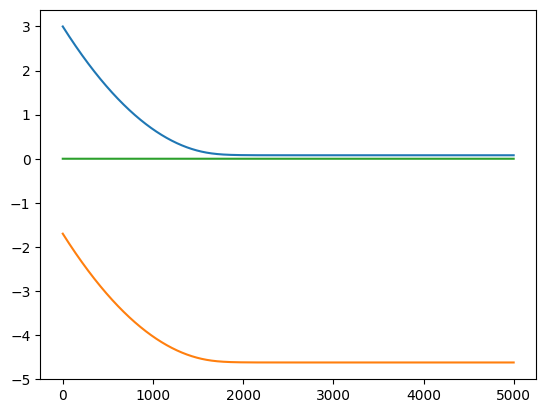

In [43]:
Ec = data["Ec"].to_numpy() #Converting the conduction band data to a numpy array. Will help in vecotizing operations and making them faster
x_vals = data["x"].to_numpy() #Converting the x-position data to a numpy array. Will help in vecotizing operations and making them faster
plt.plot(x_vals,Ec)
plt.plot(x_vals,data["Ev"]) 
plt.plot(x_vals,data["Ef"]) #plotting all three energy bands w.r.t x-pos

#### Surface Electric field
Caluclating the maximum surface elctric field based on the doping concetration

In [173]:
V_app = [-200,-45]
E_max =[]

for i in range(0,len(V_app)):
    field_at_bias= np.sqrt(2*e*donor_doping_per_cm*(barrier_h-V_app[i])/mat_perm) ##Applying the electric field formula for max electric field
    E_max = np.append(E_max, field_at_bias)
E_max

array([2597817.08717494, 1245882.76237753])

#### Modelling the conduction band
Using the equation for conduction band profile, we model the conduction band with respect to x


/var/folders/_9/6s_92dnx309df0g0kkqxd_3r0000gn/T/ipykernel_7925/3593561277.py:4: RuntimeWarning: divide by zero encountered in divide
  conductionband_0 = barrier_h - E_max[0]*surf_depth - (e/(16*math.pi*mat_perm*surf_depth)) + (e*donor_doping_per_cm*surf_depth**2/(2*mat_perm))
/var/folders/_9/6s_92dnx309df0g0kkqxd_3r0000gn/T/ipykernel_7925/3593561277.py:12: RuntimeWarning: divide by zero encountered in divide
  conductionband_1 = barrier_h - E_max[1]*surf_depth - (e/(16*math.pi*mat_perm*surf_depth)) + (e*donor_doping_per_cm*surf_depth**2/(2*mat_perm))


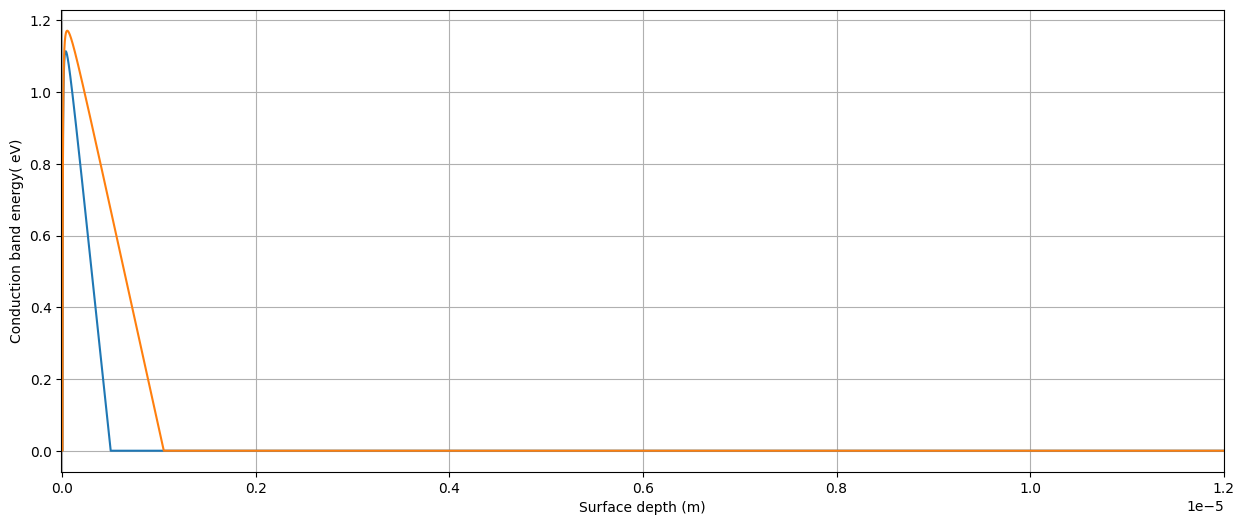

In [174]:
#calculating at 0 bias
surf_depth = np.linspace(0,120e-7,1000000)

conductionband_0 = barrier_h - E_max[0]*surf_depth - (e/(16*math.pi*mat_perm*surf_depth)) + (e*donor_doping_per_cm*surf_depth**2/(2*mat_perm))

for i in range(len(conductionband_0)):
    if conductionband_0[i] < 0:
        conductionband_0[i] = 0



conductionband_1 = barrier_h - E_max[1]*surf_depth - (e/(16*math.pi*mat_perm*surf_depth)) + (e*donor_doping_per_cm*surf_depth**2/(2*mat_perm))

for i in range(len(conductionband_1)):
    if conductionband_1[i] < 0:
        conductionband_1[i] = 0
#plotting
plt.figure(figsize=(15,6))
plt.plot(surf_depth,conductionband_0)
plt.plot(surf_depth, conductionband_1)
plt.xlabel("Surface depth (m)")
plt.xlim(left=-0.1e-7,right = 120e-7)
plt.ylabel("Conduction band energy( eV)")
plt.grid()



We will now interpolate a function for the 0 bias conduction band.

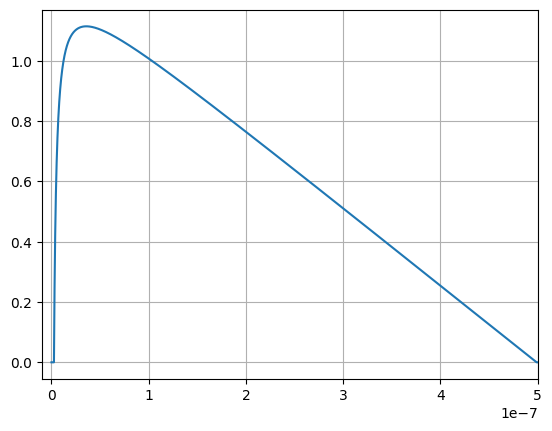

In [175]:
Ec_x = interpolate.interp1d(surf_depth,conductionband_0)
ytest = Ec_x(surf_depth)

#plotting the interpolated function
plt.plot(surf_depth,ytest)
plt.xlim(left=-0.1e-7,right=5e-7)
plt.grid()

In [176]:
# Define a list of electron energies you're interested in
electron_energies = np.linspace(0, conductionband_0.max(), 50)  # change range or density as needed

# Store turning points
turning_points = {}

# Loop over each electron energy
for E_target in electron_energies:
    def root_function(x):
        return Ec_x(x) - E_target

    # Sample conduction band values to look for crossings
    delta = Ec_x(surf_depth) - E_target
    sign_change_indices = np.where(np.diff(np.sign(delta)))[0]
    
    roots = []
    for idx in sign_change_indices:
        a = surf_depth[idx]
        b = surf_depth[idx + 1]
        try:
            root = optimize.brenth(root_function, a, b)
            roots.append(root)
        except ValueError:
            continue
    
    turning_points[E_target] = roots

del turning_points[list(turning_points.keys())[0]]


df_tp = pd.DataFrame.from_dict(turning_points, orient='index', columns=['turning point 1','turning point 2'])
df_tp.index.name = 'Electron Energy eV'
df_tp

,turning point 1,turning point 2
Electron Energy eV,,
0.022732,2.624931e-09,4.898231e-07
0.045464,2.673021e-09,4.809975e-07
0.068195,2.722911e-09,4.721697e-07
0.090927,2.774721e-09,4.633409e-07
0.113659,2.828550e-09,4.545106e-07
0.136391,2.884522e-09,4.456786e-07
0.159122,2.942765e-09,4.368449e-07
0.181854,3.003431e-09,4.280092e-07
0.204586,3.066669e-09,4.191714e-07


### Solving for transmission coefficient

In [177]:
transmission_wrt_electron_energy = {}

electron_energies_list = list(turning_points.keys())

def conductionband(x):
    return barrier_h - E_max[0]*x - (e/(16*math.pi*mat_perm*x)) + (e*donor_doping_per_cm*x**2/(2*mat_perm))

for keys, values in turning_points.items():
    def integrand(x):
        return np.sqrt(2*mass_eff*(conductionband(x) - keys))

    integral_val, _ = integrate.quad(integrand, values[0], values[1])
    exponent = -(2/6.58e-16) * integral_val
    transmission_coefficient = 1/(1+np.exp(exponent))
    transmission_wrt_electron_energy[keys] = transmission_coefficient


df = pd.DataFrame.from_dict(transmission_wrt_electron_energy, orient='index', columns=['Transmission Coefficient'])
df.index.name = 'Electron Energy (eV)'
df
df['real_part'] = df['Transmission Coefficient'].apply(lambda x: x.real)
df

,Transmission Coefficient,real_part
Electron Energy (eV),,
0.022732,0.5,0.5
0.045464,0.5,0.5
0.068195,0.5,0.5
0.090927,0.5,0.5
0.113659,0.5,0.5
0.136391,0.5,0.5
0.159122,0.5,0.5
0.181854,0.5,0.5
0.204586,0.5,0.5


<Axes: xlabel='Electron Energy (eV)'>

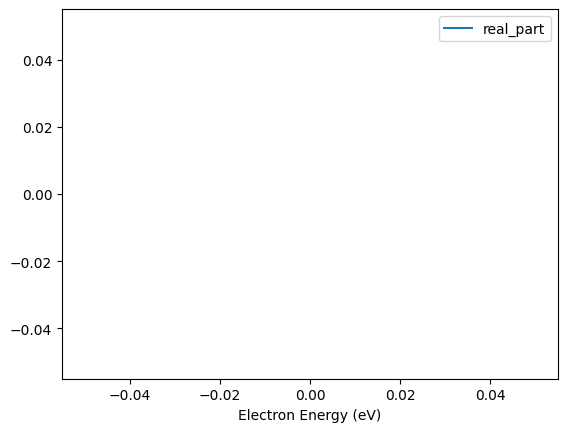

In [171]:
df.plot(y="real_part", use_index = True)


In [143]:
#0.052993	2.671018e-09	9.981443e-06
#1.221907	4.914803e-08	3.300436e-07
def conductionband(x):
    return barrier_h - E_max[0]*x - (e/(16*math.pi*mat_perm*x)) + (e*donor_doping_per_cm*x**2/(2*mat_perm))
def integrand1(x):
        return np.sqrt(2*mass_eff*(conductionband(x) - 0.052993))

integral_val1, _1 = integrate.fixed_quad(integrand1,2.671018e-09 ,9.981443e-06)

integral_val1

exp = integral_val1*(2/6.6e-16)

1/(1+np.exp(exp))

np.float64(0.499996421331861)